# League of Toronto's Neighbourhoods in Sports Centers

## Fetching Data <a name="section1"></a>

###### Import libraries 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests 
import bs4
import folium
import json
from pandas.io.json import json_normalize
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors
import time
from scipy.spatial.distance import cdist
import seaborn as sns
sns.set()

### List of postal codes (DS01) <a name="section1.1"></a>

In [3]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M')
if response.status_code == 200: 
    print ("Get Successful!")
else:
    print ("Get Failed! Check URL")

Get Successful!


###### Payload Received From Wiki

In [4]:
# print(response.text) # Commented out to avoid filling the notebook with the response text

###### Parse the response text using BeautifulSoap

In [5]:
resp_soap = bs4.BeautifulSoup(response.text, 'html.parser')
resp_soap.title

<title>List of postal codes of Canada: M - Wikipedia</title>

#### Assumptions
 * Postal Code & Borough combination is expected have same value for all the nieighbourhoods with those combinations.
 * **_check_\__for_\__discrepancy_** is used to shout if there are any discrepancies found while processing the rows. 

In [6]:
def check_for_discrepancy(pos_dict,row_list):
    
    if row_list[0] in pos_dict and pos_dict[row_list[0]][0] != row_list[1]:
        print ("Warning! Existing Postal Codes and Borough combination is differing from the new row")
        print (f"Existing Postal Code {row_list[0]} Borough {pos_dict[row_list[0]][0]}")
        print (f"New Postal Code {row_list[0]} Borough {row_list[1]}")

#### Approach
* Very first table from the Response Text will be parsed to get all the Postal Codes
* **_get_\__list_\__of_\__postal_\__codes_** will parse all the rows.
* **_get_\__row_\__list_** will parse the columns.
* Postal Code Dictionary (_with the postal code as a Key_) is maintained to store all the parsed postal codes. 
* If Borough i.e. Column #2 is "Not Assigned", it will skip adding the rows to the Postal Code Dictionary 
* If Neighbourhood i.e. Column #3 is "Not Assigned" but if the Borough is valid, it will assign the Borough as its neighbourhood before adding the row to the Dictionary. 
* The list is maintained to keep track of the Neighbourhoods that are having the same postal code
* Another List is maintained to keep track of the rows that are having valid Borough but "Not assigned" Neighbourhood

In [7]:
def add_to_dictionary(pos_dict,row_list,more_nbh):
    
    if (row_list[0]) in pos_dict:
        more_nbh.append(row_list[0])
        pos_dict[row_list[0]][1] = pos_dict[row_list[0]][1] + ", " + row_list[2]
    else:
        pos_dict[row_list[0]] = [row_list[1],row_list[2]]

In [8]:
def get_row_list(row):
    
    row_list = []    
    for column in row:
        
        if isinstance(column,bs4.element.Tag): # Avoid processing NavigableString - Mostly newline char            
            row_list.append(column.get_text(strip=True))
            
    return row_list

In [9]:
def get_list_of_postal_codes(soap_msg_table):
    
    pos_dict = {}
    more_nbh = []
    na_nbh = []
    for row in soap_msg_table:
        
        if isinstance(row,bs4.element.Tag): # Avoid processing NavigableString - Mostly newline char
            row_list = get_row_list(row)
            
            if row_list[1].replace(' ','').lower() != 'notassigned' and row_list[2].replace(' ','').lower() == 'notassigned':
                na_nbh.append(row_list[0])
                row_list[2] = row_list[1]
                add_to_dictionary(pos_dict,row_list,more_nbh)
                
            elif row_list[1].replace(' ','').lower() != 'notassigned':                
                add_to_dictionary(pos_dict,row_list,more_nbh)
            
            # Check for discrepancy
            check_for_discrepancy(pos_dict,row_list)
            
    return pos_dict,more_nbh,na_nbh

###### Extracting & Parsing the very first table from the response text

In [10]:
resp_table = resp_soap.table
postal_code_list, more_nbh, na_nbh = get_list_of_postal_codes(resp_table.tbody)

###### Creating a DataFrame from the Parsed Dictionary. 
* _orient_ is used to parse the keys as Index
* Removing the first row as it is a header from the table
* Resetting the Index to get the DataFrame in an expected way. 
* Adding the expected column names to the DataFrame 

In [11]:
pos_df = pd.DataFrame.from_dict(postal_code_list,orient='index')
pos_df = pos_df[1:]
pos_df = pos_df.reset_index()
pos_df.columns = ['PostalCode','Borough','Neighborhood']

###### Shape of the Resultant Dataframe

In [12]:
print(f"{pos_df.shape}")

(103, 3)


### Geospatial Data (DS02) <a name="section1.2"></a>

**Note:** Using the same data file provided in previous assignments.

In [13]:
!wget -q http://cocl.us/Geospatial_data

###### Read the data file into a DataFrame & Rename the columns to match the existing DataFrame

In [14]:
geo_data = pd.read_csv('Geospatial_data',header=0)
geo_data.columns = ['PostalCode','Latitude','Longitude']

In [15]:
geo_data.head(5)

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


###### Shape of the geo_data dataframe

In [16]:
print(f"{geo_data.shape}")

(103, 3)


#### Approach
* https://nominatim.openstreetmap.org/ will be queried directly to get specific Geocodes 
* foursquare api will be used to analyze the neighbourhoods. 

###### Extracting Geo Location for Toronto <a name="section1.2.2"></a>

In [17]:
def get_geo_codes(area):
    longitude = ""
    latitude = ""
    try:
        # Replace the space with +
        area_str = area.replace(" ","+")
        
        # Get the Geolocation for given area
        response = requests.get('https://nominatim.openstreetmap.org/search?q='+area_str+'&format=geojson&limit=1')
        if response.status_code == 200:
            print ("Get Successful")
            
            # Extract the Latitude & Longitude from the response text
            longitude,latitude = json.loads(response.text)['features'][0]['geometry']['coordinates']
            print(f"latitude & longitude values of {area} are {latitude},{longitude}")
        else:
            print ("Get Failed!")
    except:
        pass
    
    return latitude,longitude

###### Extract Latitude & Longitude for Toronto,ON

In [18]:
latitude,longitude = get_geo_codes('Toronto ON')

Get Successful
latitude & longitude values of Toronto ON are 43.653963,-79.387207


###### Merge the DataFrames based on Postal Codes

In [19]:
toronto_df = pos_df.merge(right=geo_data,on='PostalCode')
toronto_df.head(5)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [20]:
print(f"{toronto_df.shape}")

(103, 5)


In [21]:
print (f"There are {toronto_df['Borough'].unique().size} unique Borough's from the merged DataFrame")

There are 11 unique Borough's from the merged DataFrame


### Sports Centers (DS03) <a name="section1.3"></a>

###### Set the Credentials for Foursquare API 

In [81]:
CLIENT_ID = 'a' # your Foursquare ID
CLIENT_SECRET = 'b' # your Foursquare Secret
VERSION = '20190531' # Foursquare API version

print('Your credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentials:
CLIENT_ID: a
CLIENT_SECRET:b


###### Get Nearby Venues from each Neighbourhood
* radius is set to 2000 to have enough data points for each neighbourhood
* LIMIT is set to 100 for all the neighbourhoods. However, there may be some cases with less number of records received from the API

In [23]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    
    LIMIT = 100
    
    # Athletics & Sports {4f4528bc4b90abdf24c9de85}, Pool {4bf58dd8d48988d15e941735},    
    CATEGORY = '4f4528bc4b90abdf24c9de85,4bf58dd8d48988d15e941735'
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}&categoryId={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT,
            CATEGORY)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng,
            v['venue']['id'],
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['location']['distance'], 
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'Venue Id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude',
                  'Venue Distance', 
                  'Venue Category']
    
    return(nearby_venues)

###### Get Venues from each Neighbourhood

In [24]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighborhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

In [25]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue Id,Venue,Venue Latitude,Venue Longitude,Venue Distance,Venue Category
0,Parkwoods,43.753259,-79.329656,4b4fd4a9f964a520fd1627e3,North Beach Indoor Volleyball Academy,43.737191,-79.323714,1851,Gym / Fitness Center
1,Parkwoods,43.753259,-79.329656,4b049809f964a520725522e3,GoodLife Fitness North York Victoria Terrace,43.742234,-79.313351,1795,Gym
2,Parkwoods,43.753259,-79.329656,5310c64b498e6a6fb03c29b9,Krudar Muay Thai,43.740911,-79.320757,1549,Athletics & Sports
3,Parkwoods,43.753259,-79.329656,5070914de4b0c34b5012fdf2,Northern Karate Schools,43.754490,-79.350326,1667,Athletics & Sports
4,Parkwoods,43.753259,-79.329656,4bd4846a6798ef3bd0c5618d,Donalda Golf & Country Club,43.752816,-79.342741,1053,Golf Course


### Details for each Sports Centers (DS04) <a name="section1.4"></a>

In [26]:
def get_attr_value(resp_dict,attribute):
    
    if attribute in resp_dict:
        return resp_dict[attribute]
    
    return ''

In [27]:
def has_attr(resp_dict,attribute):
    
    return attribute in resp_dict

In [28]:
def get_reasons(curr_resp_dict,reasons):
    
    curr_resp_dict['reasons_count'] = get_attr_value(reasons,'count')
    
    items = ()
    index = 1
    for item in reasons['items']:
        curr_resp_dict[f'reasons_item_summary_{index}'] = get_attr_value(item,'summary')
        break

In [29]:
def get_all_categories(curr_resp_dict,categories):
    
    count = 1
    for item in categories:
        curr_resp_dict['sub_category_%d' % count] = get_attr_value(item,'name')
        count += 1
        if count > 3:
            break

In [30]:
def getVenueDetails(id):
    
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # make the GET request
    response_msg = requests.get(url).json()["response"]['venue']
    
    curr_resp_list = []
    curr_resp_dict = {'venue_id':response_msg['id'],'verified':'','tip_count':'',
                'likes':'','rating':'','ratingSignals':'','reasons_count':'',
                    'reasons_item_summary_1':'','sub_category_1':'','sub_category_2':'',
                         'sub_category_3':''}
    
    curr_resp_dict['verified'] = get_attr_value(response_msg,'verified')
    
    if has_attr(response_msg,'stats'):
        curr_resp_dict['tip_count'] = get_attr_value(response_msg['stats'],'tipCount')
        
    if has_attr(response_msg,'likes'):
        curr_resp_dict['likes'] = get_attr_value(response_msg['likes'],'count')
        
    if has_attr(response_msg,'categories'):
        get_all_categories(curr_resp_dict,response_msg['categories'])
    
    curr_resp_dict['rating'] = get_attr_value(response_msg,'rating')
    curr_resp_dict['ratingSignals'] = get_attr_value(response_msg,'ratingSignals')
    
    if has_attr(response_msg,'reasons'):
        get_reasons(curr_resp_dict,response_msg['reasons'])
    
    return curr_resp_dict

In [31]:
def getDetailsforallVenues(venues):
    
    venues_list = []
    
    for venue_id in venues:
        venues_list.append(getVenueDetails(venue_id))
    
    det_venues_df = pd.DataFrame(venues_list)
    
    return det_venues_df

###### Note:  Details about the venues were collected over few days and saved it in a file "toronto_venue_details_final_dataframe.csv" as *Venue* endpoint is a premium endpoint which allows only restricted number requests per day

In [32]:
# uncomment this after two days 
#toronto_venue_details = getDetailsforallVenues(toronto_unique_venues['Venue Id'])
#toronto_venue_details.head()

toronto_venue_details = pd.read_csv(r'toronto_venue_details_final_dataframe.csv',
                                names=['likes','rating','ratingSignals','reasons_count',
                                       'reasons_item_summary_1','sub_category_1','sub_category_2','sub_category_3','tip_count','Venue Id','verified'])

In [33]:
toronto_venue_details.head()

,likes,rating,ratingSignals,reasons_count,reasons_item_summary_1,sub_category_1,sub_category_2,sub_category_3,tip_count,Venue Id,verified
0,28,8.9,36.0,0,NaN,Soccer Field,Athletics & Sports,NaN,7,50a01c82e4b0a0263fcfdcb9,False
1,12,8.6,11.0,0,NaN,Athletics & Sports,Gym / Fitness Center,Tennis Court,0,4ba5156cf964a520b6da38e3,False
2,34,7.6,46.0,1,Lots of people like this place,Gym,Gym / Fitness Center,Athletics & Sports,10,4bb4ccb486a8d13a7ce1de7f,True
3,15,7.4,22.0,0,NaN,Sports Club,Social Club,Athletics & Sports,6,4b0eb057f964a520b75923e3,True
4,51,8.2,70.0,1,Lots of people like this place,Gym / Fitness Center,NaN,NaN,20,4c18e819d4d9c9284e19f029,True


## Prepare & Analyse Data

#### Analyzing Postal Code data : Postal Code with more than one neightbourhood - Eg : M5A is used

In [34]:
pos_df.loc[pos_df['PostalCode'] == 'M5A']['Neighborhood'].values

array(['Harbourfront, Regent Park'], dtype=object)

Lot of postal codes are having more than 1 neighbourhood, So, neighbourhood column in the dataframe will have comma seperated list of neighbourhoods. Few examples are listed below

In [35]:
pos_df.loc[pos_df['PostalCode'].isin(set(more_nbh))].head(5)

,PostalCode,Borough,Neighborhood
2,M5A,Downtown Toronto,"Harbourfront, Regent Park"
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
6,M1B,Scarborough,"Rouge, Malvern"
8,M4B,East York,"Woodbine Gardens, Parkview Hill"
9,M5B,Downtown Toronto,"Ryerson, Garden District"


###### Postal Codes that were having "Not assigned" neighbourhood while extracting

As highlighted in previous assignments, Borough will be used as a neighbourhood.

In [36]:
pos_df.loc[pos_df['PostalCode'].isin(set(na_nbh))]

,PostalCode,Borough,Neighborhood
4,M7A,Queen's Park,Queen's Park


#### Create a map of Toronto with neighborhoods superimposed on top.

In [37]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='green').add_to(map_toronto)  
    
map_toronto

#### Merging Venues with the Venue Details

In [38]:
toronto_mvenues = toronto_venues.merge(toronto_venue_details,left_on='Venue Id',right_on='Venue Id')

In [39]:
if toronto_mvenues.shape[0] == toronto_venues.shape[0]:
    print ("Venues are successfully merged")

Venues are successfully merged


###### Find the missing data % for the identified features

In [40]:
md_for_identified_features = ((toronto_mvenues[['Venue Distance','Venue Category','likes','rating','ratingSignals','tip_count']].isna().sum()/toronto_mvenues.shape[0])*100).reset_index()
md_for_identified_features.columns = ['features','missing %']

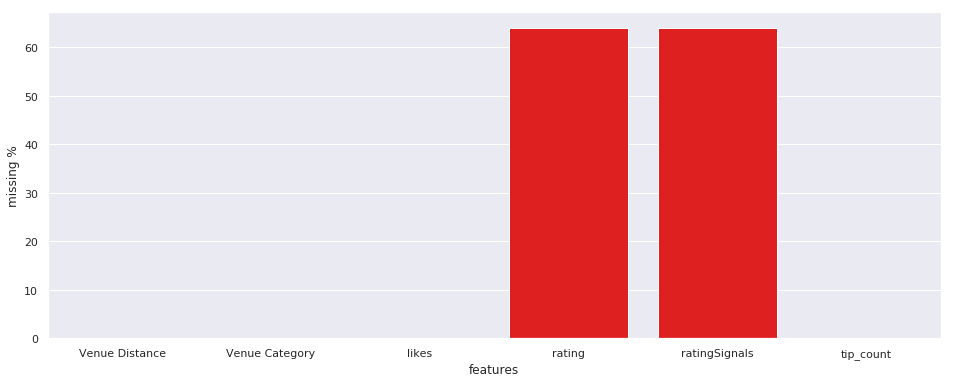

In [41]:
plt.figure(figsize=(16, 6))
ax = sns.barplot(x='features',y='missing %',data=md_for_identified_features,color='red')

##### Note: 
* Close to 65 % of rows are not having ```Rating``` & ```RatingSamples```. Will choose to discard them 
* ```reasons_count``` is going to hold the same data as reasons_summary. 
* ```verified``` is a flag from foursquare owner verification, will be discarded

###### Discard the features that are not relevant 

In [42]:
toronto_mvenues = toronto_mvenues.drop(['reasons_count','rating','ratingSignals','verified'],axis=1)

###### Category Selection. 
* Each venue can have multiple categories associated with it. 
* All the categories provided in *categories* data will be used for analysis. 
* Two broader categories were identified
* If any of the subcategories are found in *sub_category_1*, *sub_category_2* & *sub_category_3*, it will be mapped to the corresponding broader category

In [43]:
def unify_categories():
    for index, row in toronto_mvenues.iterrows():

        ath_category = ['Athletics & Sports','Tennis Court','Baseball Field','Volleyball Court','Soccer Field','Hockey Arena','Badminton Court','Basketball Court','Basketball Stadium','Golf Course','Golf Driving Range','Skating Rink','Skate Park','Skating Field','Track','Sports Club','Paintball Field','Curling Ice']
        gym_category = ['Gym','Gym / Fitness Center','Boxing Gym','Climbing Gym','Gymnastics Gym','Cycle Studio','Social Club','Gym Pool','Pool','Martial Arts Dojo','Yoga Studio','Pilates Studio','College Gym']
        if row['sub_category_1'] in ath_category or row['sub_category_2'] in ath_category or row['sub_category_3'] in ath_category:
            
            toronto_mvenues.at[index, 'Venue Category'] =  'Athletics & Sports Centers'
        elif row['sub_category_1'] in gym_category or row['sub_category_2'] in gym_category or row['sub_category_3'] in gym_category:
            
            toronto_mvenues.at[index, 'Venue Category'] =  'Fitness Centers'

In [44]:
unify_categories()

In [45]:
final_categories = toronto_mvenues[['Venue Category','Venue Id']].groupby('Venue Category').count().reset_index()

In [46]:
final_categories

,Venue Category,Venue Id
0,Athletics & Sports Centers,826
1,Fitness Centers,2539


In [47]:
impCat = SimpleImputer(strategy='constant',fill_value='')
reasons_summary=impCat.fit_transform(toronto_mvenues[['reasons_item_summary_1','Venue Category']])
#reasons_summary=impCat.transform(toronto_mvenues[['reasons_item_summary_1','Venue Category']])

In [48]:
ordenc = OrdinalEncoder()
ordenc.fit(reasons_summary)
ordcat_pd = pd.DataFrame(ordenc.transform(reasons_summary),columns=['reasons_summary','Category'])
ordcat_pd
toronto_mvenues = toronto_mvenues.merge(ordcat_pd,left_index=True,right_index=True).drop(['reasons_item_summary_1','sub_category_1','sub_category_2','sub_category_3'],axis=1)

#### Venue Distances
* plot a line from the neighbourhood to the identified venues

In [49]:
def add_polylines_to_map(map_clusters,data,ch_color):
    for row in data:
        line = [[row[1],row[2]],[row[5],row[6]]]
        polyline = folium.features.PolyLine(line,color=ch_color);
        polyline.add_to(map_clusters)

In [50]:
parkwoods_loc = toronto_mvenues.loc[toronto_mvenues['Neighborhood'] == 'Parkwoods'].loc[0]
map_clusters = folium.Map(location=[parkwoods_loc[1],parkwoods_loc[2]], zoom_start=12)

nc=0
add_polylines_to_map(map_clusters,toronto_mvenues.loc[toronto_mvenues['Neighborhood'] == 'Parkwoods'].values,'red')
add_polylines_to_map(map_clusters,toronto_mvenues.loc[toronto_mvenues['Neighborhood'] == 'Victoria Village'].values,'blue')
add_polylines_to_map(map_clusters,toronto_mvenues.loc[toronto_mvenues['Neighborhood'] == 'Flemingdon Park, Don Mills South'].values,'green')
add_polylines_to_map(map_clusters,toronto_mvenues.loc[toronto_mvenues['Neighborhood'] == 'Maryvale, Wexford'].values,'orange')
add_polylines_to_map(map_clusters,toronto_mvenues.loc[toronto_mvenues['Neighborhood'] == 'Don Mills North'].values,'grey')
add_polylines_to_map(map_clusters,toronto_mvenues.loc[toronto_mvenues['Neighborhood'] == 'Fairview, Henry Farm, Oriole'].values,'brown')


map_clusters

##### Features 

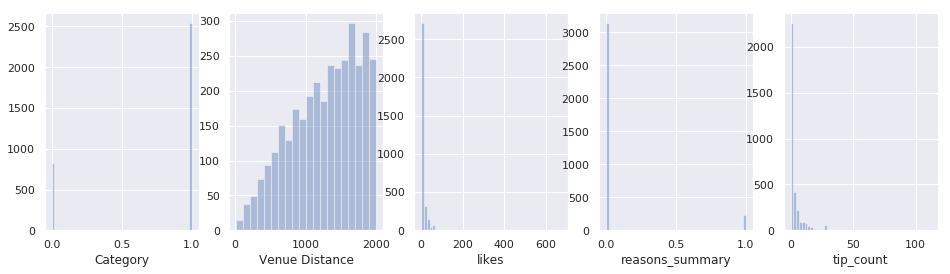

In [51]:
f, axes = plt.subplots(1, 5,figsize=(16, 4))

ax1 = sns.distplot(toronto_mvenues['Category'],kde=False,ax=axes[0])
ax2 = sns.distplot(toronto_mvenues['Venue Distance'],kde=False,ax=axes[1])
ax3 = sns.distplot(toronto_mvenues['likes'],kde=False,ax=axes[2])
ax4 = sns.distplot(toronto_mvenues['reasons_summary'],kde=False,ax=axes[3])
ax5 = sns.distplot(toronto_mvenues['tip_count'],kde=False,ax=axes[4])

###### Descriptive Statistics

In [52]:
toronto_mvenues[['Category','Venue Distance','likes','reasons_summary','tip_count']].describe()

,Category,Venue Distance,likes,reasons_summary,tip_count
count,3365.000000,3365.00000,3365.000000,3365.000000,3365.000000
mean,0.754532,1277.01367,12.341159,0.067756,3.872808
std,0.430428,481.87610,48.280216,0.251365,9.662521
min,0.000000,17.00000,0.000000,0.000000,0.000000
25%,1.000000,916.00000,1.000000,0.000000,0.000000
50%,1.000000,1346.00000,3.000000,0.000000,1.000000
75%,1.000000,1678.00000,9.000000,0.000000,3.000000
max,1.000000,2003.00000,674.000000,1.000000,112.000000


likes & tip_count has outliers. However, they provide signifant difference to the venues

###### Identify & Print the Cluster shapes

In [53]:
def print_cluster_shapes(df,cluster_label='Cluster'):
    dict_cl = {}
    for cluster in sorted(df[cluster_label].unique()):
        dict_cl[cluster] = df.loc[df[cluster_label] == cluster].shape[0]
    return dict_cl

In [54]:
features = ['Neighborhood','Category','Venue Distance','likes','reasons_summary','tip_count']

###### Group all the venues based on it's Neighborhood

In [55]:
toronto_mvenues_grouped  = toronto_mvenues[features].groupby('Neighborhood').mean().reset_index()

In [56]:
toronto_mvenues_grouped.head(5)

,Neighborhood,Category,Venue Distance,likes,reasons_summary,tip_count
0,"Adelaide, King, Richmond",0.890000,983.830000,21.490000,0.110000,5.870000
1,Agincourt,0.750000,1163.500000,6.375000,0.000000,2.000000
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0.250000,1373.916667,1.833333,0.000000,1.083333
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0.000000,1705.666667,7.000000,0.000000,0.666667
4,"Alderwood, Long Branch",0.363636,1235.090909,6.727273,0.090909,1.909091


In [57]:
toronto_mvenues_final = toronto_mvenues_grouped.drop('Neighborhood',axis=1)

##### Scale the Data

In [58]:
scaler = preprocessing.StandardScaler().fit(toronto_mvenues_final)
toronto_mvenues_final = pd.DataFrame(scaler.transform(toronto_mvenues_final))

In [59]:
toronto_mvenues_final.head(5)

,0,1,2,3,4
0,1.277060,-1.816218,2.447430,1.645076,1.685447
1,0.666147,-0.862889,-0.102588,-0.893192,-0.371103
2,-1.515683,0.253581,-0.868803,-0.893192,-0.858227
3,-2.606599,2.013845,0.002854,-0.893192,-1.079647
4,-1.019813,-0.483028,-0.043157,1.204550,-0.419413


##### Data After Scaling

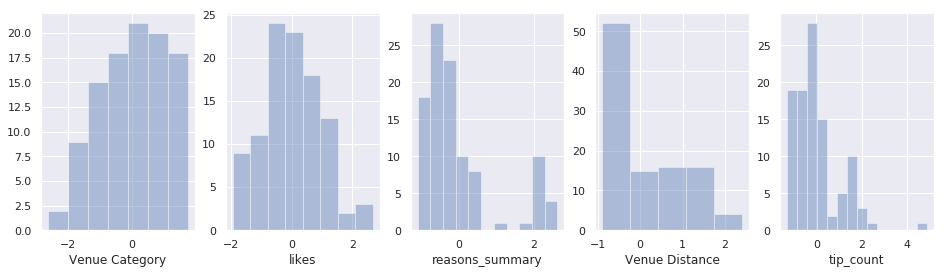

In [60]:
f, axes = plt.subplots(1, 5,figsize=(16, 4))

ax1 = sns.distplot(toronto_mvenues_final[0],kde=False,ax=axes[0],axlabel='Venue Category')
ax2 = sns.distplot(toronto_mvenues_final[1],kde=False,ax=axes[1],axlabel='likes')
ax3 = sns.distplot(toronto_mvenues_final[2],kde=False,ax=axes[2],axlabel='reasons_summary')
ax3 = sns.distplot(toronto_mvenues_final[3],kde=False,ax=axes[3],axlabel='Venue Distance')
ax3 = sns.distplot(toronto_mvenues_final[4],kde=False,ax=axes[4],axlabel='tip_count')

##### Identify the best K value using elbow method.

In [61]:
def elbow_method():

    distortions = {}
    for kclusters in range(1,25):

        kmeans = KMeans(n_clusters=kclusters, random_state=5,init='random').fit(toronto_mvenues_final)

        # check cluster labels generated for each row in the dataframe
        kmeans.labels_
        distortions[kclusters] = sum(np.min(cdist(toronto_mvenues_final, kmeans.cluster_centers_, 'euclidean'), axis=1)) / toronto_mvenues_final.shape[0]
    
    return distortions

In [62]:
distortions = elbow_method()
distortions_df = pd.DataFrame.from_dict(distortions,orient='index',columns=['0']).reset_index()
distortions_df.columns = ['Clusters','Magnitude']

##### Identify the best K 
* K value 4 - 5 may be the best value for this dataset. So choosing K value as 5 to produce the neighbourhoods

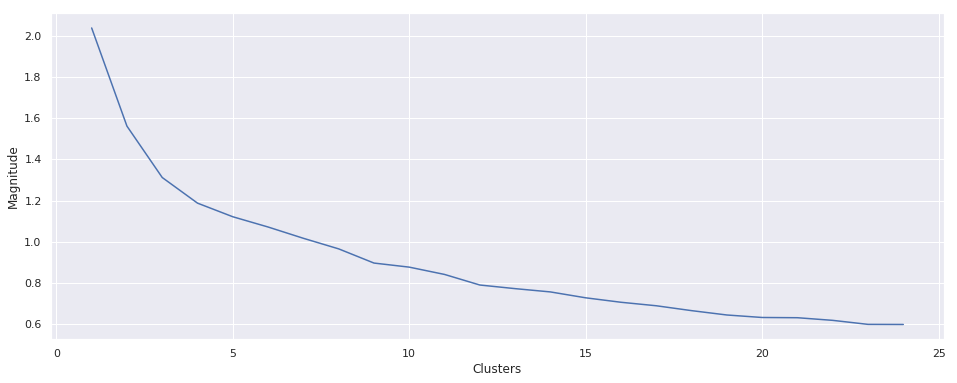

In [63]:
plt.figure(figsize=(16, 6))
ax = sns.lineplot(x="Clusters", y="Magnitude", data=distortions_df)

In [64]:
kclusters = 5

kmeans = KMeans(n_clusters=kclusters, random_state=5,init='random').fit(toronto_mvenues_final)

# check cluster labels generated for each row in the dataframe
kmeans.labels_
toronto_mvenues_grouped.insert(0, 'Cluster', kmeans.labels_)
toronto_df = toronto_df.merge(toronto_mvenues_grouped,on='Neighborhood')

In [65]:
toronto_df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster,Category,Venue Distance,likes,reasons_summary,tip_count
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,0.500000,1640.357143,7.285714,0.071429,2.357143
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,0.625000,1388.250000,5.958333,0.041667,2.791667
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,4,0.791209,1470.593407,16.989011,0.076923,4.065934
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,3,0.692308,1157.538462,4.000000,0.000000,2.307692
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494,4,0.870000,1357.530000,19.490000,0.110000,5.760000


##### Plot the clustered neighbourhoods

In [66]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
    
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.RdYlGn(np.linspace(0, 1, len(ys)+7))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_df['Latitude'], toronto_df['Longitude'],toronto_df['Neighborhood'], toronto_df['Cluster']):
    label = folium.Popup(str(poi) + '\nCluster ' + str(cluster), parse_html=True)
    folium.features.RegularPolygonMarker(
        [lat, lon],
        radius=7,
        popup=label,
        color=rainbow[np.int(cluster-1)],
        fill_color=rainbow[np.int(cluster-1)]).add_to(map_clusters)
map_clusters

##### Size of each Clusters

In [67]:
cluster_mag = print_cluster_shapes(toronto_df)
cluster_mag_df = pd.DataFrame.from_dict(cluster_mag,orient='index').reset_index()
cluster_mag_df.columns = ['Cluster','Size']
cluster_mag_df.head()

,Cluster,Size
0,0,24
1,1,20
2,2,14
3,3,28
4,4,17


##### Neighbourhoods in each cluster

In [80]:
toronto_df.loc[toronto_df['Cluster'] == 0]['Neighborhood'].values

array(['Cloverdale, Islington, Martin Grove, Princess Gardens, West Deane Park',
       'Woodbine Heights',
       'Bloordale Gardens, Eringate, Markland Wood, Old Burnhamthorpe',
       'Guildwood, Morningside, West Hill', 'Woburn',
       'Scarborough Village', 'Northwood Park, York University',
       'East Birchmount Park, Ionview, Kennedy Park', 'Bayview Village',
       'Silver Hills, York Mills', 'Downsview West',
       'Downsview, North Park, Upwood Park', 'Humber Summit',
       'Newtonbrook, Willowdale', 'Bedford Park, Lawrence Manor East',
       'Lawrence Park',
       'Dorset Park, Scarborough Town Centre, Wexford Heights',
       'Willowdale West',
       'Kingsview Village, Martin Grove Gardens, Richview Gardens, St. Phillips',
       "Clarks Corners, Sullivan, Tam O'Shanter",
       "Agincourt North, L'Amoreaux East, Milliken, Steeles East",
       'Albion Gardens, Beaumond Heights, Humbergate, Jamestown, Mount Olive, Silverstone, South Steeles, Thistletown',
       'U

In [69]:
toronto_df.loc[toronto_df['Cluster'] == 1]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster,Category,Venue Distance,likes,reasons_summary,tip_count
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,0.500000,1640.357143,7.285714,0.071429,2.357143
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,0.625000,1388.250000,5.958333,0.041667,2.791667
6,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353,1,0.428571,1516.428571,9.428571,0.142857,1.000000
21,M6E,York,Caledonia-Fairbanks,43.689026,-79.453512,1,0.866667,1532.000000,4.666667,0.066667,7.066667
25,M6G,Downtown Toronto,Christie,43.669542,-79.422564,1,0.727273,1341.309091,8.854545,0.054545,3.072727
27,M2H,North York,Hillcrest Village,43.803762,-79.363452,1,0.444444,1189.222222,9.333333,0.111111,4.444444
40,M3K,North York,"CFB Toronto, Downsview East",43.737473,-79.464763,1,0.478261,1422.347826,8.000000,0.086957,2.956522
43,M6K,West Toronto,"Brockton, Exhibition Place, Parkdale Village",43.636847,-79.428191,1,0.737705,1256.065574,10.245902,0.081967,3.524590
62,M5N,Central Toronto,Roselawn,43.711695,-79.416936,1,0.621622,1355.540541,5.864865,0.054054,2.378378
63,M6N,York,"The Junction North, Runnymede",43.673185,-79.487262,1,0.500000,1425.611111,5.888889,0.055556,5.611111


In [70]:
toronto_df.loc[toronto_df['Cluster'] == 2]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster,Category,Venue Distance,likes,reasons_summary,tip_count
5,M9A,Etobicoke,Islington Avenue,43.667856,-79.532242,2,0.000000,958.250000,4.250000,0.000000,1.000000
7,M3B,North York,Don Mills North,43.745906,-79.352188,2,0.363636,980.454545,7.818182,0.090909,2.636364
8,M4B,East York,"Woodbine Gardens, Parkview Hill",43.706397,-79.309937,2,0.250000,1163.083333,3.666667,0.000000,2.916667
23,M4G,East York,Leaside,43.709060,-79.363452,2,0.611111,967.611111,4.444444,0.000000,2.500000
29,M4H,East York,Thorncliffe Park,43.705369,-79.349372,2,0.500000,972.285714,5.714286,0.000000,3.285714
33,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,2,0.357143,1086.571429,1.500000,0.000000,0.428571
51,M1M,Scarborough,"Cliffcrest, Cliffside, Scarborough Village West",43.716316,-79.239476,2,0.500000,1087.500000,1.500000,0.000000,1.000000
57,M9M,North York,"Emery, Humberlea",43.724766,-79.532242,2,0.250000,1308.500000,4.000000,0.000000,1.750000
58,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848,2,0.375000,1168.625000,4.125000,0.000000,2.625000
60,M3N,North York,Downsview Northwest,43.761631,-79.520999,2,0.500000,1225.300000,4.200000,0.000000,0.700000


In [71]:
toronto_df.loc[toronto_df['Cluster'] == 3]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster,Category,Venue Distance,likes,reasons_summary,tip_count
3,M6A,North York,"Lawrence Heights, Lawrence Manor",43.718518,-79.464763,3,0.692308,1157.538462,4.000000,0.000000,2.307692
10,M6B,North York,Glencairn,43.709577,-79.445073,3,0.764706,1225.058824,2.352941,0.000000,1.823529
12,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497,3,1.000000,1307.500000,1.500000,0.000000,0.500000
13,M3C,North York,"Flemingdon Park, Don Mills South",43.725900,-79.340923,3,0.611111,1188.611111,4.388889,0.000000,2.000000
16,M6C,York,Humewood-Cedarvale,43.693781,-79.428191,3,0.807692,1496.769231,2.923077,0.000000,1.346154
19,M4E,East Toronto,The Beaches,43.676357,-79.293031,3,0.520000,1314.680000,3.480000,0.000000,1.520000
26,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3,0.937500,1277.750000,5.875000,0.000000,2.875000
28,M3H,North York,"Bathurst Manor, Downsview North, Wilson Heights",43.754328,-79.442259,3,0.600000,1308.500000,0.600000,0.000000,0.700000
31,M6H,West Toronto,"Dovercourt Village, Dufferin",43.669005,-79.442259,3,0.729730,1333.675676,7.459459,0.027027,1.972973
35,M4J,East York,East Toronto,43.685347,-79.338106,3,0.785714,1401.464286,5.321429,0.035714,2.500000


In [72]:
toronto_df.loc[toronto_df['Cluster'] == 4]

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster,Category,Venue Distance,likes,reasons_summary,tip_count
2,M5A,Downtown Toronto,"Harbourfront, Regent Park",43.654260,-79.360636,4,0.791209,1470.593407,16.989011,0.076923,4.065934
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494,4,0.870000,1357.530000,19.490000,0.110000,5.760000
9,M5B,Downtown Toronto,"Ryerson, Garden District",43.657162,-79.378937,4,0.900000,1237.490000,21.130000,0.110000,6.060000
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,4,0.880000,1186.000000,19.560000,0.080000,5.190000
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,4,0.880000,1263.730000,19.160000,0.080000,5.060000
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,4,0.920000,1275.120000,22.490000,0.130000,6.520000
30,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568,4,0.890000,983.830000,21.490000,0.110000,5.870000
36,M5J,Downtown Toronto,"Harbourfront East, Toronto Islands, Union Station",43.640816,-79.381752,4,0.870000,1130.830000,19.450000,0.080000,5.230000
37,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,4,0.755814,1275.558140,14.011628,0.093023,4.581395
42,M5K,Downtown Toronto,"Design Exchange, Toronto Dominion Centre",43.647177,-79.381576,4,0.890000,969.900000,20.230000,0.090000,5.440000
